# PLEASE CLONE THIS NOTEBOOK INTO YOUR PERSONAL FOLDER
# DO NOT RUN CODE IN THE SHARED FOLDER

### !!!!Note to GRADERS!!!!
team members included: Basumitra Chaki, Chukwudera (Dera), Lucas Schroyer, Taehoon Kang

section number: 2

link: https://adb-6759024569771990.10.azuredatabricks.net/?o=6759024569771990#notebook/1921115853668227/revision/1636268321584

# HW 5 - Page Rank
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__

In Weeks 8 and 9 you discussed key concepts related to graph based algorithms and implemented SSSP.   
In this final homework assignment you'll implement distributed PageRank using some data from Wikipedia.
By the end of this homework you should be able to:  
* ... __compare/contrast__ adjacency matrices and lists as representations of graphs for parallel computation.
* ... __explain__ the goal of the PageRank algorithm using the concept of an infinite Random Walk.
* ... __define__ a Markov chain including the conditions underwhich it will converge.
* ... __identify__ what modifications must be made to the web graph inorder to leverage Markov Chains.
* ... __implement__ distributed PageRank in Spark.

__Please refer to the `README` for homework submission instructions and additional resources.__

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [0]:
# RUN THIS CELL AS IS. 
tot = 0
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
for item in dbutils.fs.ls(DATA_PATH):
  tot = tot+item.size
tot
# ~4.7GB

Out[2]: 4751198766

In [0]:
# RUN THIS CELL AS IS. You should see all-pages-indexed-in.txt, all-pages-indexed-out.txt and indices.txt in the results. If you do not see these, please let an Instructor or TA know.
display(dbutils.fs.ls(DATA_PATH))

path,name,size
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt,all-pages-indexed-in.txt,2143300687
dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt,all-pages-indexed-out.txt,2090459616
dbfs:/mnt/mids-w261/HW5/indices.txt,indices.txt,517438296
dbfs:/mnt/mids-w261/HW5/test_graph.txt,test_graph.txt,167


In [0]:
sc = spark.sparkContext
spark

Out[4]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.1.2 
 Master 
 spark://10.0.128.28:7077 
 AppName 
 Databricks Shell

# Question 1: Distributed Graph Processing
Chapter 5 from Lin & Dyer gave you a high level introduction to graph algorithms and concernts that come up when trying to perform distributed computations over them. The questions below are designed to make sure you captured the key points from this reading and your async lectures. 

### Q1 Tasks:

* __a) short response:__ Give an example of a dataset that would be appropriate to represent as a graph. What are the nodes/edges in this dataset? Is the graph you describe 'directed' or 'undirected'? What would the average "in-degree" of a node mean in the context of your example? 

* __b) short response:__ Other than their size/scale, what makes graphs uniquely challenging to work with in the map-reduce paradigm? *(__HINT__: Do not respond in terms of any specific algorithm. Think in terms of the nature of the graph datastructure itself).*

* __c) short response:__ Briefly describe Dijskra's algorithm (goal/approach). What specific design component makes this approach hard to parallelize?

* __d) short response:__ How does parallel breadth-first-search get around the problem that you identified in part `c`? At what expense?

### Q1 Student Answers:
> __a)__ A dataset of LinkedIn profiles and contacts could be represented as a graph. The nodes would be the user names and the edges would be which users are connected with which other users. This dataset would be undirected since users have to be connected with each other (i.e. you cannot follow one direction). The average "in-degree" of a node is the number of connections an individual user has

> __b)__ Adjacency matrix are hard to distribute and are very large/sparse (e.g. the # of actual connections is tiny compared to the # of possible edges). With adjacency list, computing anything that requires knowledge of incoming links of a node is difficult (i.e. they don't work well with stateless environments). Graphs also can be difficult to design in a map-reduce framework as graphs are made from nodes and edges so it can be difficult to design what computations can be distributed for parallel computations and which need to be co-located.

> __c)__ Dijskra's algorithm iteratively updates the path distance between a source node and every other node. The key to this alogrithm is the priority queue that maintains a globally sorted list of nodes by current distance - which is not possible in map reduce since it requires access to global data. Algorithm is sequential.

> __d)__ Parallel breadth-first-search uses an iterative approach rather than the global priority queue where each MapReduce iteration is a like a round of priority queue update via Dijksrka's but at the expense where we need another way to decide when the MapReduce should stop iterating. Another downside is all the nodes connected to a source node need to be processed with each iteration, which is very comutationally comprehensive but allows for parallelization.

# Question 2: Representing Graphs 

In class you saw examples of adjacency matrix and adjacency list representations of graphs. These data structures were probably familiar from HW3, though we hadn't before talked about them in the context of graphs. In this question we'll discuss some of the tradeoffs associated with these representations. __`NOTE:`__ We'll use the graph from Figure 5.1 in Lin & Dyer as a toy example. For convenience in the code below we'll label the nodes `A`, `B`, `C`, `D`, and `E` instead of $n_1$, $n_2$, etc but otherwise you should be able to follow along & check our answers against those in the text.


<img src="https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/Lin-Dyer-graph-Q1.png?raw=true" width=50%>

### Q2 Tasks:

* __a) short response:__ Relatively speaking, is the graph you described in Figure 5.1 in Lin & Dyer "sparse" or "dense"?  Explain how sparsity/density impacts the adjacency matrix and adjacency list representations of a graph.

* __b) short response:__ Run the provided code to create and plot our toy graph. Is this graph directed or undirected? Explain how the adjacency matrices for directed graphs will differ from those of undirected graphs.

* __c) code:__ Fill in the missing code to complete the function `get_adj_matr()`.

* __d) code:__ Fill in the missing code to complete the function `get_adj_list()`.

### Q2 Student Answers:
> __a)__ Adjancency matrix are very sparse... Matrix is good for representing dense graphs and list is good for sparse graphs computationally.

The sparsity/density impacts how many zeroes will be represented in the adjacency matrix which means most of the matrix may contain zeros which does not carry any information in our computation. While with the adjacency list will only represent the useful information which is the nodes connected to the key.

> __b)__ The graph is directed. Undirected adjacency matrices are symetric (i.e. only need half of the table) about the diagnoal while undirected are not.

In [0]:
# part a - a graph is just a list of nodes and edges (RUN THIS CELL AS IS)
TOY_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
             'edges':[('A', 'B'), ('A', 'D'), ('B', 'C'), ('B', 'E'), ('C', 'D'), 
                      ('D', 'E'), ('E', 'A'),('E', 'B'), ('E', 'C')]}

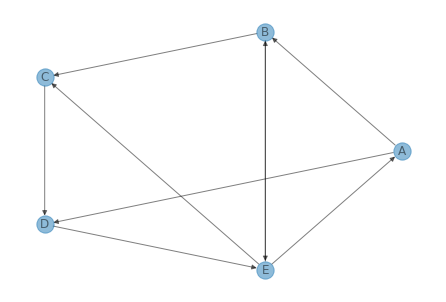

In [0]:
# part a - simple visualization of our toy graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY_GRAPH['nodes'])
G.add_edges_from(TOY_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part c - adjacency matrix function
def get_adj_matr(graph):
    """
    Function to create an adjacency matrix representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        pd.DataFrame with entry i,j representing an edge from node i to node j
    """
    n = len(graph['nodes'])
    adj_matr = pd.DataFrame(0, columns = graph['nodes'], index = graph['nodes'])
    ############### YOUR CODE HERE ##################
#     print(adj_matr)
    for row_i, col_i in graph['edges']:
#       print(row_i, "-", col_i)
#       print(adj_matr.loc[row_i, col_i])
      adj_matr.loc[row_i, col_i] += 1 
    
    
    ############### (END) YOUR CODE #################
    return adj_matr

In [0]:
# part c - take a look (RUN THIS CELL AS IS)
TOY_ADJ_MATR = get_adj_matr(TOY_GRAPH)
print(TOY_ADJ_MATR)

A B C D E
A 0 1 0 1 0
B 0 0 1 0 1
C 0 0 0 1 0
D 0 0 0 0 1
E 1 1 1 0 0

In [0]:
# part d - adjacency list function
def get_adj_list(graph):
    """
    Function to create an adjacency list representation of a graph.
    arg:
        graph - (dict) of 'nodes' : [], 'edges' : []
    returns:
        dictionary of the form {node : [list of edges]}
    """
    adj_list = {node: [] for node in graph['nodes']}
    ############### YOUR CODE HERE ##################
    for row_i, col_i in graph['edges']:
#       print(row_i, "-", col_i)
#       print(adj_matr.loc[row_i, col_i])
      adj_list[row_i].append(col_i)  
    
    ############### (END) YOUR CODE #################
    return adj_list

In [0]:
# part d - take a look (RUN THIS CELL AS IS)
TOY_ADJ_LIST = get_adj_list(TOY_GRAPH)
print(TOY_ADJ_LIST)

{'A': ['B', 'D'], 'B': ['C', 'E'], 'C': ['D'], 'D': ['E'], 'E': ['A', 'B', 'C']}

# Question 3: Markov Chains and Random Walks

As you know from your readings and in class discussions, the PageRank algorithm takes advantage of the machinery of Markov Chains to compute the relative importance of a webpage using the hyperlink structure of the web (we'll refer to this as the 'web-graph'). A Markov Chain is a discrete-time stochastic process. The stochastic matrix has a principal left eigen vector corresponding to its largest eigen value which is one. A Markov chain's probability distribution over its states may be viewed as a probability vector. This steady state probability for a state is the PageRank of the corresponding webpage. In this question we'll briefly discuss a few concepts that are key to understanding the math behind PageRank. 

### Q3 Tasks:

* __a) short response:__ It is common to explain PageRank using the analogy of a web surfer who clicks on links at random ad infinitum. In the context of this hypothetical infinite random walk, what does the PageRank metric measure/represent?

* __b) short response:__ What is the "Markov Property" and what does it mean in the context of PageRank?

* __c) short response:__ A Markov chain consists of $n$ states plus an $n\times n$ transition probability matrix. In the context of PageRank & a random walk over the WebGraph what are the $n$ states? what implications does this have about the size of the transition matrix?

* __d) code + short response:__ What is a "right stochastic matrix"? Fill in the code below to compute the transition matrix for the toy graph from question 2. [__`HINT:`__ _It should be right stochastic. Using numpy this calculation can be done in one line of code._]

* __e) code + short response:__ To compute the stable state distribution (i.e. PageRank) of a "nice" graph we can apply the power iteration method - repeatedly multiplying the transition matrix by itself, until the values no longer change. Apply this strategy to your transition matrix from `part d` to find the PageRank for each of the pages in your toy graph. Your code should print the results of each iteration. How many iterations does it take to converge? Which node is most 'central' (i.e. highest ranked)? Does this match your intuition? 
    * __`NOTE 1:`__ _this is a naive approach, we'll unpack what it means to be "nice" in the next question_.
    * __`NOTE 2:`__ _no need to implement a stopping criteria, visual inspection should suffice_.

### Q3 Student Answers:
> __a)__ Probability that the surfer will land on a particular website after infinite jumps.

> __b)__ Markov property refers to a stochasic process where the conditional probability distribution of future states of the process depends only on the present state, not on the sequence of events that preceded it (i.e. it is memoryless). In the context of PageRank, the Markov process gives us the approach to calculate the page rank of each webpage. The probability of visiting the next page depends on the current page the user is in.

> __c)__ The n states are the n webpages. Given the current state of the walker, each row of the matrix gives the probability that the walker will transition to each new state. The transition matrix is a n x n matrix.

> __d)__ Right stochastic matrix: the sum of the row probabilities is equal to 100%. 

> __e)__ It took roughly 20 iterations to converge. Node E is the most central. It matches with my intuition because both B and D point E, and D itself is a high rank node.

In [0]:
# part d - recall what the adjacency matrix looked like (RUN THIS CELL AS IS)
TOY_ADJ_MATR

Out[11]:

,A,B,C,D,E
A,0,1,0,1,0
B,0,0,1,0,1
C,0,0,0,1,0
D,0,0,0,0,1
E,1,1,1,0,0


In [0]:
# part d - use TOY_ADJ_MATR to create a right stochastic transition matrix for this graph
################ YOUR CODE HERE #################
# transition_matrix = None # replace with your code
# print(np.diagflat(np.sum(TOY_ADJ_MATR, axis=1).to_list()))
# print(np.sum(TOY_ADJ_MATR, axis=1).to_list())

transition_matrix = np.dot(np.linalg.inv(np.diagflat(np.sum(TOY_ADJ_MATR, axis=1).to_list())),TOY_ADJ_MATR)
#transition_matrix = TOY_ADJ_MATR.div(TOY_ADJ_MATR.sum(axis=1), axis=0)
################ (END) YOUR CODE #################
print(transition_matrix)

[[0. 0.5 0. 0.5 0. ]
 [0. 0. 0.5 0. 0.5 ]
 [0. 0. 0. 1. 0. ]
 [0. 0. 0. 0. 1. ]
 [0.33333333 0.33333333 0.33333333 0. 0. ]]

In [0]:
# part e - compute the steady state using the transition matrix 
def power_iteration(xInit, tMatrix, nIter, verbose = True):
    """
    Function to perform the specified number of power iteration steps to 
    compute the steady state probability distribution for the given
    transition matrix.
    
    Args:
        xInit     - (n x 1 array) representing inial state
        tMatrix  - (n x n array) transition probabilities
        nIter     - (int) number of iterations
    Returns:
        state_vector - (n x 1 array) representing probability 
                        distribution over states after nSteps.
    
    NOTE: if the 'verbose' flag is on, your function should print the step
    number and the current matrix at each iteration.
    """
    state_vector = None
    
    ################ YOUR CODE HERE #################
    state_vector = xInit
    for ix in range(nIter):    
        new_state_vector = state_vector@tMatrix
        state_vector = new_state_vector
        
        if verbose:
            print(f'Step {ix}: {state_vector}')
            
#     new_state_vector = state_vector@tMatrix
#     state_vector = new_state_vector
    
    
    ################ (END) YOUR CODE #################
    return state_vector

In [0]:
# part e - run 10 steps of the power_iteration (RUN THIS CELL AS IS)
xInit = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
states = power_iteration(xInit, transition_matrix, 10, verbose = True)
print()
[print("Node ", val, ": ", states[i], sep = "") for i, val in enumerate(TOY_GRAPH['nodes'])]

Step 0: [0. 0.5 0. 0.5 0. ]
Step 1: [0. 0. 0.25 0. 0.75]
Step 2: [0.25 0.25 0.25 0.25 0. ]
Step 3: [0. 0.125 0.125 0.375 0.375]
Step 4: [0.125 0.125 0.1875 0.125 0.4375]
Step 5: [0.14583333 0.20833333 0.20833333 0.25 0.1875 ]
Step 6: [0.0625 0.13541667 0.16666667 0.28125 0.35416667]
Step 7: [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
Step 8: [0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]
Step 9: [0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]

Node A: 0.09085648148148147
Node B: 0.1490162037037037
Node C: 0.17853009259259256
Node D: 0.24913194444444442
Node E: 0.33246527777777773
Out[14]: [None, None, None, None, None]

__`Expected Output for part e:`__  
>Steady State Probabilities:
```
Node A: 0.10526316  
Node B: 0.15789474  
Node C: 0.18421053  
Node D: 0.23684211  
Node E: 0.31578947  
```

# Question 4: Page Rank Theory

Seems easy right? Unfortunately applying this power iteration method directly to the web-graph actually runs into a few problems. In this question we'll tease apart what we meant by a 'nice graph' in Question 3 and highlight key modifications we'll have to make to the web-graph when performing PageRank. To start, we'll look at what goes wrong when we try to repeat our strategy from question 3 on a 'not nice' graph.

__`Additional References:`__ http://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html

### Q4 Tasks:

* __a) code + short response:__ Run the provided code to create and plot our 'not nice' graph. Fill in the missing code to compute its transition matrix & run the power iteration method from question 3. What is wrong with what you see? [__`HINT:`__ _there is a visible underlying reason that it isn't converging... try adding up the probabilities in the state vector after each iteration._]

* __b) short response:__  Identify the dangling node in this 'not nice' graph and explain how this node causes the problem you described in 'a'. How could we modify the transition matrix after each iteration to prevent this problem?

* __c) short response:__ What does it mean for a graph to be irreducible? Is the webgraph naturally irreducible? Explain your reasoning briefly.

* __d) short response:__ What does it mean for a graph to be aperiodic? Is the webgraph naturally aperiodic? Explain your reasoning briefly.

* __e) short response:__ What modification to the webgraph does PageRank make in order to guarantee aperiodicity and irreducibility? Interpret this modification in terms of our random surfer analogy.

### Q4 Student Answers:
> __a)__ The probabilities are not adding up to 100%. By looking at the iteration outputs, we can see that the probability at each state keeps dropping and the sum of the state vector probabilities is converging towards zero. By looking at the toy graph, we notice that the graph is not irreducible in which the node E is a dangling node, so it does not contribute to the page ranking of any page. This prevents the state vector from converging.

> __b)__ Node D is the dangling node as it does not have any edges leading away from it. One fix would be to redistribute the loss mass.

> __c)__ If it is possible to get to any state from any state. Webgraph is not naturally irreducible since it is possible for a web page to not have any external links.

> __d)__  A graph is aperiodic if the cycles aren'nt structured where we can predict - based on a prior step - the exact steps to get to a particular state. Webgraph are not naturally periodic since we could find ourselves in a graph situation in which it is as likely to head down one circular loop as the next, resulting in an ever oscillating chance that we would head to one web page as another as the number of steps approaches infinity. 

> __e)__ Random Jump factor adds a small amount of probability to each node to teleport to any other node, thus guaranteeing aperiodicity because we can't predict the exact steps to get to a state and guarantees irreducivility since there is now a path from any state to another. The surfer has a small probability of going to any url link manually that it could not go to before without the random jump.

In [0]:
# part a - run this code to create a second toy graph (RUN THIS CELL AS IS)
TOY2_GRAPH = {'nodes':['A', 'B', 'C', 'D', 'E'],
              'edges':[('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'D'), 
                       ('B', 'E'), ('C', 'A'), ('C', 'E'), ('D', 'B')]}

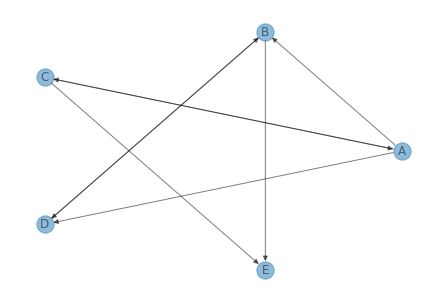

In [0]:
# part a - simple visualization of our test graph using nx (RUN THIS CELL AS IS)
G = nx.DiGraph()
G.add_nodes_from(TOY2_GRAPH['nodes'])
G.add_edges_from(TOY2_GRAPH['edges'])
display(nx.draw(G, pos=nx.circular_layout(G), with_labels=True, alpha = 0.5))

In [0]:
# part a - run 10 steps of the power iteration method here
# HINT: feel free to use the functions get_adj_matr() and power_iteration() you wrote above
################ YOUR CODE HERE #################
xInit2 = np.array([1.0, 0, 0, 0, 0]) # note that this initial state will not affect the convergence states
# xInit2 = get_adj_matr(TOY2_GRAPH).iloc[0].to_numpy()
print(xInit2)

states2 = power_iteration(xInit2, transition_matrix, 100, verbose = True)


#########################

#irrMatrix = get_adj_matr(TOY2_GRAPH)
#transition_matrix = irrMatrix.div(irrMatrix.sum(axis=1), axis=0).fillna(0)
xInit2 = np.array([1.0, 0, 0, 0, 0])
state2 = power_iteration(xInit, transition_matrix, 25, verbose = True)

################ (END) YOUR CODE #################

[1. 0. 0. 0. 0.]
Step 0: [0. 0.5 0. 0.5 0. ]
Step 1: [0. 0. 0.25 0. 0.75]
Step 2: [0.25 0.25 0.25 0.25 0. ]
Step 3: [0. 0.125 0.125 0.375 0.375]
Step 4: [0.125 0.125 0.1875 0.125 0.4375]
Step 5: [0.14583333 0.20833333 0.20833333 0.25 0.1875 ]
Step 6: [0.0625 0.13541667 0.16666667 0.28125 0.35416667]
Step 7: [0.11805556 0.14930556 0.18576389 0.19791667 0.34895833]
Step 8: [0.11631944 0.17534722 0.19097222 0.24479167 0.27256944]
Step 9: [0.09085648 0.1490162 0.17853009 0.24913194 0.33246528]
Step 10: [0.11082176 0.15625 0.18532986 0.22395833 0.32364005]
Step 11: [0.10788002 0.1632909 0.18600502 0.24074074 0.30208333]
Step 12: [0.10069444 0.15463445 0.18233989 0.23994502 0.32238619]
Step 13: [0.10746206 0.15780928 0.18477929 0.23268711 0.31726225]
Step 14: [0.10575408 0.15948511 0.18465873 0.23851032 0.31159176]
Step 15: [0.10386392 0.15674096 0.18360648 0.23753577 0.31825288]
Step 16: [0.10608429 0.15801625 0.18445477 0.23553844 0.31590625]
Step 17: [0.10530208 0.15834423 0.18431021 0.23749692 0.31454656]
Step 18: [0.10484885 0.1574999 0.18402097 0.23696125 0.31666903]
Step 19: [0.10555634 0.15798077 0.18430629 0.2364454 0.3157112 ]
Step 20: [0.10523707 0.15801524 0.18422745 0.23708446 0.31543578]
Step 21: [0.10514526 0.15776379 0.18415288 0.23684598 0.31609208]
Step 22: [0.10536403 0.15793666 0.18424592 0.23672551 0.31572788]
Step 23: [0.10524263 0.15792464 0.18421096 0.23692794 0.31569384]
Step 24: [0.10523128 0.15785259 0.1841936 0.23683227 0.31589026]
Step 25: [0.10529675 0.15791239 0.18422305 0.23680924 0.31575857]
Step 26: [0.10525286 0.15790123 0.18420905 0.23687143 0.31576544]
Step 27: [0.10525515 0.15788157 0.18420576 0.23683548 0.31582204]
Step 28: [0.10527401 0.15790159 0.1842148 0.23683333 0.31577627]
Step 29: [0.10525876 0.15789576 0.18420955 0.23685181 0.31578413]
Step 30: [0.10526138 0.15789075 0.18420926 0.23683893 0.31579969]
Step 31: [0.10526656 0.15789725 0.18421194 0.23683994 0.3157843 ]
Step 32: [0.10526143 0.15789472 0.18421006 0.23684522 0.31578857]
Step 33: [0.10526286 0.15789357 0.18421021 0.23684078 0.31579258]
Step 34: [0.10526419 0.15789562 0.18421098 0.23684164 0.31578756]
Step 35: [0.10526252 0.15789462 0.18421033 0.23684308 0.31578945]
Step 36: [0.10526315 0.15789441 0.18421046 0.23684159 0.31579038]
Step 37: [0.10526346 0.15789504 0.18421067 0.23684204 0.3157888 ]
Step 38: [0.10526293 0.15789466 0.18421045 0.2368424 0.31578955]
Step 39: [0.10526318 0.15789465 0.18421052 0.23684192 0.31578973]
Step 40: [0.10526324 0.15789484 0.18421057 0.23684211 0.31578924]
Step 41: [0.10526308 0.1578947 0.1842105 0.23684219 0.31578953]
Step 42: [0.10526318 0.15789472 0.18421053 0.23684204 0.31578954]
Step 43: [0.10526318 0.15789477 0.18421054 0.23684211 0.3157894 ]
Step 44: [0.10526313 0.15789472 0.18421052 0.23684213 0.3157895 ]
Step 45: [0.10526317 0.15789473 0.18421053 0.23684208 0.31578949]
Step 46: [0.10526316 0.15789475 0.18421053 0.23684211 0.31578945]
Step 47: [0.10526315 0.15789473 0.18421052 0.23684211 0.31578948]
Step 48: [0.10526316 0.15789474 0.18421053 0.2368421 0.31578948]
Step 49: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 50: [0.10526316 0.15789473 0.18421053 0.23684211 0.31578948]
Step 51: [0.10526316 0.15789474 0.18421053 0.2368421 0.31578947]
Step 52: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 53: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578948]
Step 54: [0.10526316 0.15789474 0.18421053 0.2368421 0.31578947]
Step 55: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 56: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 57: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 58: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 59: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 60: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 61: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 62: [0.10526316 0.15789474 0.18421053 0.23684211 0.31578947]
Step 63: [0.10526316 

# About the Data
The main dataset for this data consists of a subset of a 500GB dataset released by AWS in 2009. The data includes the source and metadata for all of the Wikimedia wikis. You can read more here: 
> https://aws.amazon.com/blogs/aws/new-public-data-set-wikipedia-xml-data. 

As in previous homeworks we'll be using a 2GB subset of this data, which is available to you in this dropbox folder: 
> https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0. 

Use the cells below to download the wikipedia data and a test file for use in developing your PageRank implementation(note that we'll use the 'indexed out' version of the graph) and to take a look at the files.

In [0]:
dbutils.fs.ls(DATA_PATH)

Out[18]: [FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-in.txt', name='all-pages-indexed-in.txt', size=2143300687),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/all-pages-indexed-out.txt', name='all-pages-indexed-out.txt', size=2090459616),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/indices.txt', name='indices.txt', size=517438296),
 FileInfo(path='dbfs:/mnt/mids-w261/HW5/test_graph.txt', name='test_graph.txt', size=167)]

In [0]:
# open test_graph.txt file to see format (RUN THIS CELL AS IS)
with open('/dbfs/mnt/mids-w261/HW5/test_graph.txt', "r") as f_read:
  for line in f_read:
    print(line)

2	{'3': 1}

3	{'2': 2}

4	{'1': 1, '2': 1}

5	{'4': 3, '2': 1, '6': 1}

6	{'2': 1, '5': 2}

7	{'2': 1, '5': 1}

8	{'2': 1, '5': 1}

9	{'2': 1, '5': 1}

10	{'5': 1}

11	{'5': 2}

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

In [0]:
# display testRDD (RUN THIS CELL AS IS)
testRDD.take(10)

Out[21]: ["2\t{'3': 1}",
 "3\t{'2': 2}",
 "4\t{'1': 1, '2': 1}",
 "5\t{'4': 3, '2': 1, '6': 1}",
 "6\t{'2': 1, '5': 2}",
 "7\t{'2': 1, '5': 1}",
 "8\t{'2': 1, '5': 1}",
 "9\t{'2': 1, '5': 1}",
 "10\t{'5': 1}",
 "11\t{'5': 2}"]

In [0]:
# display indexRDD (RUN THIS CELL AS IS)
indexRDD.take(10)

Out[22]: ['! $var = &quot;&quot;\t1\t1\t0',
 '! (CONFIG.SYS directive)\t2\t1\t1',
 '! (album)\t3\t12\t17',
 '! (disambiguation)\t4\t1\t20',
 '! -attention-\t5\t1\t0',
 '! Time Zone\t6\t1\t0',
 '!! (chess)\t7\t0\t1',
 '!! (disambiguation)\t8\t3\t0',
 '!!! (Chk Chk Chk)\t9\t1\t0',
 '!!! (album)\t10\t5\t15']

In [0]:
# display wikiRDD (RUN THIS CELL AS IS)
wikiRDD.take(10)

Out[23]: ["73\t{'14417532': 1}",
 "299\t{'4214575': 1}",
 "2552\t{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}",
 "2570\t{'983991': 1}",
 "2616\t{'9045350': 1}",
 "2711\t{'752887': 1}",
 "2818\t{'3534183': 1}",
 "2847\t{'3797918': 1}",
 "2892\t{'2893': 1}",
 "2921\t{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}"]

# Question 5: EDA part 1 (number of nodes)

As usual, before we dive in to the main analysis, we'll peform some exploratory data anlysis to understand our dataset. Please use the test graph that you downloaded to test all your code before running the full dataset.

### Q5 Tasks:
* __a) short response:__ In what format is the raw data? What does the first value represent? What does the second part of each line represent? [__`HINT:`__ _no need to go digging here, just visually inspect the outputs of the head commands that we ran after loading the data above._]

* __b) code + short response:__ Run the provided bash command to count the number of records in the raw dataset. Explain why this is _not_ the same as the number of total nodes in the graph.

* __c) code:__ In the space provided below write a Spark job to count the _total number_ of nodes in this graph. 

* __d) short response:__ How many dangling nodes are there in this wikipedia graph? [__`HINT:`__ _you should not need any code to answer this question._]

### Q5 Student Answers:
> __a)__ The raw data is in adjacency list format. The first value represents the start node of the graph. The second part represents the list of to-nodes of the starting node and their corresponding weights (as represented by number of links).

> __b)__ There are 5,781,290 records in the wiki dataset. This is not the same as the number of total nodes in the graph because it does not include dangling nodes.

> __d)__ There are 9,410,987 dangling nodes (total nodes 15,192,277 - number of record 5,781,290).

In [0]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
# 5781290
print(wikiRDD.count())

5781290

In [0]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
    def emitNodes(x):
      node, edges = x.split("\t")
      yield str(node)
      for edgenode in ast.literal_eval(edges).keys():
        yield (edgenode)
        
    totalCount = dataRDD.flatMap(emitNodes).distinct().count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [0]:
# part c - run your counting job on the test file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(testRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 0.9618194103240967 seconds.
Total Nodes: 11

In [0]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print(f'Total Nodes: {tot}')

... completed job in 316.9840724468231 seconds.
Total Nodes: 15192277

# Question 6 - EDA part 2 (out-degree distribution)

As you've seen in previous homeworks the computational complexity of an implementation depends not only on the number of records in the original dataset but also on the number of records we create and shuffle in our intermediate representation of the data. The number of intermediate records required to update PageRank is related to the number of edges in the graph. In this question you'll compute the average number of hyperlinks on each page in this data and visualize a distribution for these counts (the out-degree of the nodes). 

### Q6 Tasks:
* __a) code:__ In the space provided below write a Spark job to stream over the data and compute all of the following information:
 * count the out-degree of each non-dangling node and return the names of the top 10 pages with the most hyperlinks
 * find the average out-degree for all non-dangling nodes in the graph
 * take a 1000 point sample of these out-degree counts and plot a histogram of the result. 
 
 
* __b) short response:__ In the context of the PageRank algorithm, how is information about a node's out degree used?

* __c) short response:__ What does it mean if a node's out-degree is 0? In PageRank how will we handle these nodes differently than others?
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q6 Student Answers:

> __b)__ The node's out degree is used to calculate the probability of each out-ward link.

> __c)__ When the out-degree of a node  is 0, it means the node is a dangling node. We would add a random jump factor so that a surfer can "teleport" from those nodes to any random node.

In [0]:
# part a - write your Spark job here (compute average in-degree, etc)
def count_degree(dataRDD, n):
    """
    Function to analyze out-degree of nodes in a a graph.
    Returns: 
        top  - (list of 10 tuples) nodes with most edges
        avgDegree - (float) average out-degree for non-dangling nodes
        sampledCounts - (list of integers) out-degree for n randomly sampled non-dangling nodes
    """
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    ############## YOUR CODE HERE ###############
    def out_degree(line):
      origin, destination = line
      for weight in destination.values():
        yield (origin, weight)
      
    totalOut = dataRDD.map(parse).flatMap(out_degree).reduceByKey(lambda a, b: a+b).cache() # sum up the out-degree
    top = totalOut.takeOrdered(n, key=lambda x: -x[1]) # extract sorted values from the last(largest) for n times
    avgDegree = totalOut.map(lambda x: x[1]).mean() # take mean of out-degrees
    sampledCounts = totalOut.map(lambda x: x[1]).takeSample(False, n)
    
    ############## (END) YOUR CODE ###############
    
    return top, avgDegree, sampledCounts

In [0]:
# part a - run your job on the test file (RUN THIS CELL AS IS)
start = time.time()
test_results = count_degree(testRDD,10)
print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", test_results[1])
print("Top 10 nodes (by out-degree:)\n", test_results[0])

... completed job in 0.656308650970459 seconds
Average out-degree: 2.2
Top 10 nodes (by out-degree:)
 [('5', 5), ('6', 3), ('4', 2), ('8', 2), ('9', 2), ('7', 2), ('11', 2), ('3', 2), ('10', 1), ('2', 1)]

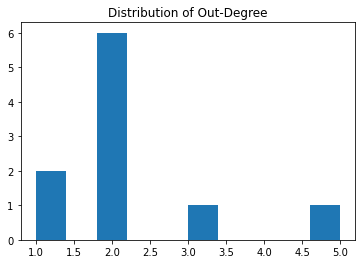

In [0]:
# part a - plot results from test file (RUN THIS CELL AS IS)
plt.hist(test_results[2], bins=10)
plt.title("Distribution of Out-Degree")
display(plt.show())

In [0]:
# part a - run your job on the full file (RUN THIS CELL AS IS)
start = time.time()
full_results = count_degree(wikiRDD,1000)

print(f"... completed job in {time.time() - start} seconds")
print("Average out-degree: ", full_results[1])
print("Top 10 nodes (by out-degree:)\n", full_results[0])

... completed job in 186.30330228805542 seconds
Average out-degree: 32.04181575392296
Top 10 nodes (by out-degree:)
 [('7804599', 9347), ('7858931', 8910), ('11185362', 8837), ('7705822', 8142), ('5760310', 7649), ('7865920', 7608), ('7819767', 7278), ('7883280', 7231), ('13035895', 7126), ('7880980', 6904), ('7909437', 6599), ('7810869', 6486), ('7846493', 6386), ('7841582', 6379), ('7768780', 6211), ('7820711', 6180), ('7861935', 6102), ('6075450', 6021), ('7884831', 6005), ('7777185', 5984), ('7803276', 5881), ('6074992', 5870), ('434078', 5856), ('7828359', 5853), ('7773411', 5806), ('7834538', 5788), ('10526976', 5772), ('7828391', 5606), ('1008643', 5599), ('7873008', 5595), ('7812439', 5554), ('7881486', 5552), ('7773479', 5523), ('7820535', 5520), ('7871067', 5517), ('7882833', 5504), ('7902703', 5471), ('7847103', 5449), ('5988470', 5421), ('7872661', 5419), ('7914303', 5369), ('5988469', 5363), ('7848337', 5344), ('11670785', 5341), ('7884903', 5234), ('6075178', 5217), ('6075732', 5183), ('7831837', 5162), ('7839409', 5112), ('6835653', 5103), ('7803274', 5081), ('7785602', 5054), ('9643124', 5026), ('7911689', 4983), ('9643132', 4969), ('7887218', 4890), ('7911235', 4881), ('7884931', 4860), ('7727417', 4859), ('7810198', 4838), ('7854241', 4830), ('10852744', 4783), ('7848322', 4768), ('7850777', 4708), ('7884930', 4683), ('8353825', 4640), ('7885241', 4594), ('11670104', 4592), ('7870424', 4591), ('7909901', 4572), ('7865253', 4559), ('7832957', 4557), ('7780859', 4548), ('7818538', 4516), ('7808359', 4506), ('1499631', 4497), ('7821232', 4480), ('7818786', 4475), ('7705731', 4469), ('7730890', 4388), ('7771799', 4381), ('7723295', 4375), ('7910325', 4344), ('7924296', 4342), ('7842595', 4316), ('7718040', 4262), ('7848357', 4233), ('417917', 4216), ('7848397', 4209), ('7828342', 4198), ('5988430', 4198), ('8353819', 4192), ('7828361', 4172), ('7911901', 4165), ('7847637', 4154), ('7913908', 4136), ('7871687', 4126), ('7700951', 4110), ('7888805', 4096), ('7884835', 4092), ('9160075', 4085), ('7805430', 4069), ('1085485', 4068), ('3544227', 4064), ('7895366', 4061), ('7862604', 3992), ('7846598', 3984), ('6412827', 3975), ('7913337', 3967), ('231671', 3959), ('2872120', 3955), ('7798689', 3944), ('7848743', 3904), ('7808617', 3896), ('7886237', 3883), ('210273', 3866), ('7848777', 3862), ('9579460', 3856), ('7753557', 3852), ('7809554', 3844), ('12600698', 3840), ('3208264', 3827), ('11670102', 3819), ('7700893', 3809), ('7885223', 3805), ('7729133', 3795), ('7865486', 3780), ('6835647', 3780), ('7850847', 3769), ('7804983', 3767), ('7872026', 3767), ('7848363', 3762), ('7766806', 3751), ('7810354', 3746), ('10840883', 3714), ('7907670', 3712), ('13034432', 3700), ('6075694', 3687), ('7883781', 3686), ('7725278', 3683), ('7884250', 3661), ('8565898', 3657), ('1436267', 3652), ('253171', 3647), ('5761250', 3641), ('7753531', 3626), ('7835185', 3616), ('7766871', 3601), ('7753564', 3597), ('7828384', 3592), ('215215', 3588), ('4414287', 3585), ('7908653', 3582), ('7829195', 3581), ('7888984', 3578), ('7753562', 3576), ('7739442', 3564), ('7716746', 3555), ('7803543', 3549), ('12917366', 3541), ('6412821', 3529), ('267405', 3526), ('291984', 3524), ('6075471', 3522), ('436883', 3512), ('4412439', 3511), ('6075569', 3507), ('2439781', 3496), ('7807492', 3488), ('7705812', 3488), ('7895370', 3486), ('398537', 3486), ('205348', 3483), ('7805565', 3483), ('5195853', 3483), ('7753538', 3479), ('385853', 3469), ('8565906', 3458), ('7885270', 3458), ('7705642', 3452), ('7737307', 3449), ('3544237', 3449), ('7812280', 3441), ('7827295', 3436), ('7725421', 3435), ('7704282', 3431), ('7831825', 3430), ('6075039', 3427), ('7780520', 3425), ('7842303', 3412), ('7753575', 3409), ('7834471', 3396), ('7754702', 3378), ('349979', 3377), ('7753532', 3375), ('403781', 3370), ('7885752', 3369), ('332025', 3368), ('9164285', 3368), ('7871574', 3357), ('7872896', 3356), ('7894899', 3353), ('7890380', 3350), ('8642302', 3348), ('200869',

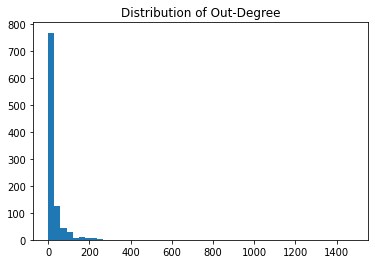

In [0]:
# part a - plot results from full file (RUN THIS CELL AS IS)
plt.hist(full_results[2], bins=50)
plt.title("Distribution of Out-Degree")
display(plt.show())

# Question 7 - PageRank part 1 (Initialize the Graph)

One of the challenges of performing distributed graph computation is that you must pass the entire graph structure through each iteration of your algorithm. As usual, we seek to design our computation so that as much work as possible can be done using the contents of a single record. In the case of PageRank, we'll need each record to include a node, its list of neighbors and its (current) rank. In this question you'll initialize the graph by creating a record for each dangling node and by setting the initial rank to 1/N for all nodes. 

__`NOTE:`__ Your solution should _not_ hard code \\(N\\).

### Q7 Tasks:
* __a) short response:__ What is \\(N\\)? Use the analogy of the infinite random web-surfer to explain why we'll initialize each node's rank to \\(\frac{1}{N}\\). (i.e. what is the probabilistic interpretation of this choice?)

* __b) short response:__ Will it be more efficient to compute \\(N\\) before initializing records for each dangling node or after? Explain your reasoning.

* __c) code:__ Fill in the missing code below to create a Spark job that:
  * parses each input record
  * creates a new record for any dangling nodes and sets it list of neighbors to be an empty set
  * initializes a rank of 1/N for each node
  * returns a pair RDD with records in the format specified by the docstring


* __d) code:__ Run the provided code to confirm that your job in `part a` has a record for each node and that your should records match the format specified in the docstring and the count should match what you computed in question 5. [__`TIP:`__ _you might want to take a moment to write out what the expected output should be fore the test graph, this will help you know your code works as expected_]
 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q7 Student Answers:

> __a)__ 
 N is the number of nodes in the graph. Since the importance of a web page is measured by its popularity when, starting the random surfing each page has equal probablity of being chosen as a starting point hence 1/N is used to initialize the nodes rank (even distribution of probability). 

> __b)__ It will be more efficient to compute N before initializing records for each dangling node. This way, we can have 1/N handy when initializing the dangling nodes' records. Otherwise, we would need another pass to update 1/N for all nodes.

In [0]:

# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # Input format:
    #  ["2\t{'3': 1}",
    #  "3\t{'2': 2}",
    #  "4\t{'1': 1, '2': 1}",
    #  "5\t{'4': 3, '2': 1, '6': 1}"...]
    
    # Output format -
    # [("2", (score1, 3)), 
    # ("3", (score2, 2)), 
    # ("4", (score3, 1)), 
    # ("4", (score4, 2)), 
    # ("5", (score5, 4))..., 
    
    # write any helper functions here

    ############## YOUR CODE HERE ###############

    # write any helper functions here
    # helper func
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def initNodes(x):
      node, edges = x.split("\t")
      yield (str(node), [])
      for edgenode in ast.literal_eval(edges).keys():
        yield (edgenode, [])
    
  # Input Format:
  #  [('2', {'3': 1}),
  #  ('3', {'2': 2}),
    def nodes(line):
      origin, destination = line
      for dest in destination.keys():
        weight=destination[dest]
        yield (dest, [])
        for weight_i in range(weight):
          yield(origin, [int(dest)])

    
    def combineEdges(x, y):
        if x=='': return y
        elif y=='': return x
        else: return x+','+y
  
  
    def mergeJoinValues(values):
      if None in values:
        #retain empty list
        return values[0]
      else:
        #merge lists
        return values[0]+values[1]
        
    
    # write your main Spark code here
 
    #initialize empty list for all nodes
    initRDD = dataRDD.flatMap(initNodes)  \
                                .reduceByKey(lambda a, b: a + b).cache()
        
    listRDD = dataRDD.map(parse).flatMap(nodes)  \
                                .reduceByKey(lambda a, b: a + b).cache()
    
#     listRDD = dataRDD.map(parse).flatMap(nodes)  \
#                                 .reduceByKey(combineEdges).cache()
#     graphRDD = listRDD
    score = 1/initRDD.count()
    sc.broadcast(score)
    
    graphRDD = initRDD.leftOuterJoin(listRDD)  \
                      .mapValues(mergeJoinValues)  \
                      .mapValues(lambda x: (score, x))

    ############## (END) YOUR CODE ##############
    
    
    return graphRDD

In [0]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.45662736892700195 seconds.
Out[72]: [('8', (0.09090909090909091, [2, 5])),
 ('9', (0.09090909090909091, [2, 5])),
 ('10', (0.09090909090909091, [5])),
 ('4', (0.09090909090909091, [1, 2])),
 ('1', (0.09090909090909091, [])),
 ('2', (0.09090909090909091, [3])),
 ('3', (0.09090909090909091, [2, 2])),
 ('5', (0.09090909090909091, [4, 4, 4, 2, 6])),
 ('6', (0.09090909090909091, [2, 5, 5])),
 ('7', (0.09090909090909091, [2, 5])),
 ('11', (0.09090909090909091, [5, 5]))]

In [0]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 558.8135411739349 seconds

In [0]:
# part c - confirm record format and count (RUN THIS CELL AS IS)
start = time.time()
print(f'Total number of records: {wikiGraphRDD.count()}')
print(f'First record: {wikiGraphRDD.take(1)}')
print(f'... initialization continued: {time.time() - start} seconds')

Total number of records: 15192277
First record: [('10509791', (6.582291778908455e-08, [2437837, 10355161, 7586245, 9153637, 9061783, 4948077, 10366330, 10860460, 604526, 604526, 15117356, 14482968, 14482968, 8386648, 2080674, 12346916, 14965911, 5342179, 7455792, 2248547, 2248547, 8258360, 5240459, 11449934, 6363843, 1876208, 11187877, 12050765, 12050765, 12050765, 12050765, 14686571, 14686571, 9832640, 6541122, 6070650, 14990207, 12055740, 7381094, 10184302, 7665619, 7665619, 8333401, 1761278, 3348860, 11961138, 1946275, 3784854, 12940249, 12940249, 14051456, 2192979, 7586242, 7586242, 7586242, 7586242, 7586242, 7586242, 15118433, 4587664, 13024582, 13024582, 13024582, 13024582, 13024582, 4828381, 1788634, 5167880, 5167880, 14517508, 11919902, 5240170, 15045269, 9866156, 9866156, 12346929, 2532724, 14148199, 14876092, 13328970, 7463773, 1947111, 11135119, 11135119, 11135119, 10753989, 10447352, 14978814, 14978814, 14511337, 14511337, 1947095, 11133476, 1347060, 3190423, 7167327, 7167327, 11099857, 7586249, 550675, 6150307, 6150307, 6150307, 9103871, 12280346, 12280346, 12280346, 3556108, 4443009, 4443009, 11102316, 13089808, 13089808, 13089808, 2222638, 2222638, 2222638, 12036519, 12036519, 2012219, 2012219, 6582776, 13203613, 13203613, 1861975, 10433298, 10433298, 10433298, 10433298, 14984555, 5467798, 8874074, 14083623, 7236835, 10665003, 14743666, 6694475, 6694475, 14656519, 9128717, 14351798, 4442195, 15176975, 5279314, 5279314, 5279314, 14820087, 5390018, 15118064, 15118064, 10315722, 5725757, 5342360, 11246987, 11246987, 11246987, 11246987, 5599929, 10229821, 4750734, 13591834, 4802496, 4802496, 4802496, 4802496, 9056492, 730444, 2004058, 1734974, 10481174, 10509782, 10509782, 5972758, 6404031, 13093207, 708160, 708160, 14719095, 14719095, 981395, 981395, 1516699, 14960632, 14612353, 13648345, 3598915, 824195, 824195, 7463906, 12992242, 7983010, 7983010, 7983010, 13070734, 13070734, 13070734, 13070734, 8146394, 4442997, 3591832, 2012921, 2777522, 14142532, 14142532, 11532605, 11532605, 8530676, 8530676, 9742161, 13121259, 13121259, 14719104, 5239935, 10481047, 10481047, 10481047, 6508023, 6508023, 15114640, 12544875, 12544875, 12544875, 12544875, 5969355, 5969355, 12992241, 2024048, 2239253, 2239253, 2239253, 2239253, 14482922, 1238146, 1947275, 12836211, 9053611, 4752441, 9868776, 9868776, 9379186, 10252884, 10252884, 10509831, 10816440, 6548260, 10451431, 10451431, 14132869, 14132869, 8785222, 6537833, 2043932, 3110157, 14046024, 7682231, 4081232, 4081232, 12993566, 4465448, 4465448, 4455197, 12101970, 12101970, 12101970, 12101970, 12101970, 4841562, 4736190, 11961122, 6926734, 13105540, 6839673, 1018141, 5664335, 3245014, 14098720, 1244888, 1244888, 1244888, 6444530, 6444530, 6444530, 6444530, 6444530, 9285891, 12367157, 1184540, 1184540, 1184540, 7449370, 7449370, 7449370, 7449370, 7449370, 11053432, 11053432, 14855523, 11368338, 11368338, 11368338, 11368338, 11368338, 11368338, 7992414, 4210875, 10864005, 3944839, 3037812, 3037812, 1991681, 10949060, 12108951, 9868876, 10600805, 8681835, 15112159, 14908021, 14908021, 11002996, 3142261, 7586241, 3037514, 3037514]))]
... initialization continued: 1176.230666399002 seconds

# Question 8 - PageRank part 2 (Iterate until convergence)

Finally we're ready to compute the page rank. In this last question you'll write a Spark job that iterates over the initialized graph updating each nodes score until it reaches a convergence threshold. The diagram below gives a visual overview of the process using a 5 node toy graph. Pay particular attention to what happens to the dangling mass at each iteration.

<img src='https://github.com/kyleiwaniec/w261_assets/blob/master/images/HW5/PR-illustrated.png?raw=true' width=50%>



__`A Note about Notation:`__ The formula above describes how to compute the updated page rank for a node in the graph. The $P$ on the left hand side of the equation is the new score, and the $P$ on the right hand side of the equation represents the accumulated mass that was re-distributed from all of that node's in-links. Finally, $|G|$ is the number of nodes in the graph (which we've elsewhere refered to as $N$).

### Q8 Tasks:
* __a) short response:__ In terms of the infinite random walk analogy, interpret the meaning of the first term in the PageRank calculation: $\alpha * \frac{1}{|G|}$

* __b) short response:__ In the equation for the PageRank calculation above what does $m$ represent and why do we divide it by $|G|$?

* __c) short response:__ Keeping track of the total probability mass after each update is a good way to confirm that your algorithm is on track. How much should the total mass be after each iteration?

* __d) code:__ Fill in the missing code below to create a Spark job that take the initialized graph as its input then iterates over the graph and for each pass:
  * reads in each record and redistributes the node's current score to each of its neighbors
  * uses an accumulator to add up the dangling node mass and redistribute it among all the nodes. (_Don't forget to reset this accumulator after each iteration!_)
  * uses an accumulator to keep track of the total mass being redistributed.( _This is just for your own check, its not part of the PageRank calculation. Don't forget to reset this accumulator after each iteration._)
  * aggregates these partial scores for each node
  * applies telportation and damping factors as described in the formula above.
  * combine all of the above to compute the PageRank as described by the formula above.
  * 
  
   __WARNING:__ Some pages contain multiple hyperlinks to the same destination, please take this into account when redistributing the mass.

 
__`NOTE:`__ Please observe scalability best practices in the design of your code & comment your work clearly. You will be graded on both the clarity and the design.

### Q8 Student Answers:

> __a)__ Type your answer here!     
It represents a smaller, but positive percentage of the time where the surfer will stop selecting hyperlink from the current page and choose arbitrarily a different page from the web and "teleport" there. This damping factor $\alpha$ reflects the probability that the surfer quits the current page and "teleports" to a new one. Since the surfer can teleport to any web page, each page has $\frac{1}{|G|}$ probability to be chosen.

> __b)__ `m` is the initial page rank credit as we got from Q7 above. G is the one we used to call N from Q7. We divide it by |G| to evenly distribute the probability from dangling nodes to each node. This helps make the graph irreducible for the distribution to converge. 

> __c)__ The total mass should be 100% after each iteration.

In [0]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [0]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    totAccum = sc.accumulator(0.0, FloatAccumulatorParam())
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    G = sc.broadcast(graphInitRDD.count())

    
    #Input format:
    #     ('4', (0.09090909090909091, [1, 2]))
    def map_long(line):
      node_id = line[0]
      m = line[1][0] #inital score
      s = line[1][1]
      yield (node_id, (0.0, s, m))  
      for key in s:
        yield (str(key), (m/len(s), [], m))
    
    #Input format:
    # ('4', (0.0, [1, 2], 0.09090909090909091))
    # ('1', (0.045454545454545456, [], 0.09090909090909091))
    # ('2', (0.045454545454545456, [], 0.09090909090909091))
    def reduce_accumulate_mass(line_1, line_2):
      score = line_1[0] + line_2[0]
      neigh_list = line_1[1] + line_2[1]
      m = line_1[2]
      return (score, neigh_list, m)
      
    # Increment the accumulators (mmAccum and totAccum).
    def inc_accum(line):
        node, (rank, edges) = line
        totAccum.add(rank)
        if edges == '' or edges == []: 
            mmAccum.add(rank)
    
    #Input format:
    # ('1', (0.045454545454545456, [], 0.09090909090909091)) <- no node outward from 1
    # ('10', (0.0, [5], 0.09090909090909091)) <- no node leading to 10
    # ('11', (0.0, [5], 0.09090909090909091)) <- no node leading to 11
    # ('2', (0.3484848484848485, [3], 0.09090909090909091)) <- node 2 leads to 3 and other nodes lead to 2
    def new_score(line):
      key = str(line[0])
      score = line[1][0]
      neigh_list = line[1][1]
      m = line[1][2]
      P = teleport_val.value + d.value*(mmass_per_node.value+score)
#       P = a.value/G.value + d.value*(m/G.value + score)
      return (key, (P, neigh_list))
    
    #Initialize RDD
    steadyStateRDD = graphInitRDD
    
    # Initialize mmAccum
    graphInitRDD.filter(lambda line: line[1][1]==[]) \
                .foreach(lambda line: mmAccum.add(line[1][0]))
    
    for iter in range(maxIter):
      
      # Compute and broadcast relevant parameters for the mappers to use
      # in applying the PageRank formula.
      teleport_val = sc.broadcast(np.divide(a.value,G.value))
      m = mmAccum.value
      mmass_per_node = sc.broadcast(np.divide(m,G.value))
    
      #Map Reduce Pipeline
      graphInitRDD_long = steadyStateRDD.flatMap(map_long)
      graphInitRDD_scores = graphInitRDD_long.reduceByKey(reduce_accumulate_mass)
      steadyStateRDD = graphInitRDD_scores.map(new_score).cache()

      # Reset mmAccum to zero and then initialize 
      # iteration's values. 
      mmAccum = sc.accumulator(0.0, FloatAccumulatorParam()) 
      steadyStateRDD.foreach(inc_accum)

      if verbose:
          print('--->STEP {}: missing mass = {}, total = {}'.
                format(iter, m, totAccum.value))
      
      totAccum = sc.accumulator(0.0, FloatAccumulatorParam())

    #Final Output with the nodes and probability masses only.
    steadyStateRDD = steadyStateRDD.map(lambda x: (x[0], x[1][0]))
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

In [0]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 4.506067991256714 seconds.
Top 20 ranked nodes:
Out[87]: [('2', 0.3620640495978871),
 ('3', 0.333992700474142),
 ('5', 0.08506399429624555),
 ('4', 0.06030963508473455),
 ('1', 0.04255740809817991),
 ('6', 0.03138662354831139),
 ('8', 0.01692511778009981),
 ('9', 0.01692511778009981),
 ('10', 0.01692511778009981),
 ('7', 0.01692511778009981),
 ('11', 0.01692511778009981)]

__`expected results for the test graph:`__
```
[(2, 0.3620640495978871),
 (3, 0.333992700474142),
 (5, 0.08506399429624555),
 (4, 0.06030963508473455),
 (1, 0.04255740809817991),
 (6, 0.03138662354831139),
 (8, 0.01692511778009981),
 (10, 0.01692511778009981),
 (7, 0.01692511778009981),
 (9, 0.01692511778009981),
 (11, 0.01692511778009981)]
```

In [0]:
# part d - run PageRank on the full graph (RUN THIS CELL AS IS)
# NOTE: wikiGraphRDD should have been computed & cached above!
nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
full_results.takeOrdered(20, key=lambda x: - x[1])

--->STEP 0: missing mass = 0.6194586235839131, total = 0.9999999999744016
--->STEP 1: missing mass = 0.4962366552052482, total = 0.9999999999795742
--->STEP 2: missing mass = 0.4584589663883813, total = 0.9999999999746516
--->STEP 3: missing mass = 0.44518624578839405, total = 0.9999999999793499
--->STEP 4: missing mass = 0.4402014781797532, total = 0.9999999999820793
--->STEP 5: missing mass = 0.43818412109071725, total = 0.9999999999853535
--->STEP 6: missing mass = 0.4373267618587026, total = 0.999999999992673
--->STEP 7: missing mass = 0.43694515814087764, total = 0.9999999999924858
--->STEP 8: missing mass = 0.4367684897169962, total = 0.9999999999905202
--->STEP 9: missing mass = 0.43668343042475766, total = 0.9999999999894682
...trained 10 iterations in 12059.791163921356 seconds.
Top 20 ranked nodes:
Out[89]: [('13455888', 0.0015447247129693749),
 ('4695850', 0.0006710240718848026),
 ('5051368', 0.000598385680969542),
 ('1184351', 0.0005982073536424848),
 ('2437837', 0.0004624928928899026),
 ('6076759', 0.0004550940064106107),
 ('4196067', 0.00044237788883337315),
 ('13425865', 0.0004415535171391662),
 ('6172466', 0.00042240020018091397),
 ('1384888', 0.0004012895604045896),
 ('6113490', 0.000395789247715308),
 ('14112583', 0.00039438472837163385),
 ('7902219', 0.0003700987847324778),
 ('10390714', 0.0003650264964294827),
 ('12836211', 0.0003619948863075178),
 ('6237129', 0.00035195558475935627),
 ('6416278', 0.00034866235644962873),
 ('13432150', 0.000339365106370982),
 ('1516699', 0.0003329750028594672),
 ('7990491', 0.0003076090626557396)]

In [0]:
top_20 = full_results.takeOrdered(20, key=lambda x: - x[1])

In [0]:
# Save the top_20 results to disc for use later. So you don't have to rerun everything if you restart the cluster.

#Expected Results
# top_20 = 
# [(13455888, 0.0015447247129832947),
#  (4695850, 0.0006710240718906518),
#  (5051368, 0.0005983856809747697),
#  (1184351, 0.0005982073536467391),
#  (2437837, 0.0004624928928940748),
#  (6076759, 0.00045509400641448284),
#  (4196067, 0.0004423778888372447),
#  (13425865, 0.00044155351714348035),
#  (6172466, 0.0004224002001845032),
#  (1384888, 0.0004012895604073632),
#  (6113490, 0.00039578924771805474),
#  (14112583, 0.0003943847283754762),
#  (7902219, 0.000370098784735699),
#  (10390714, 0.0003650264964328283),
#  (12836211, 0.0003619948863114985),
#  (6237129, 0.0003519555847625285),
#  (6416278, 0.00034866235645266493),
#  (13432150, 0.00033936510637418247),
#  (1516699, 0.00033297500286244265),
#  (7990491, 0.00030760906265869104)]

#My Results:
# Top 20 ranked nodes:
# Out[89]: [('13455888', 0.0015447247129693749),
#  ('4695850', 0.0006710240718848026),
#  ('5051368', 0.000598385680969542),
#  ('1184351', 0.0005982073536424848),
#  ('2437837', 0.0004624928928899026),
#  ('6076759', 0.0004550940064106107),
#  ('4196067', 0.00044237788883337315),
#  ('13425865', 0.0004415535171391662),
#  ('6172466', 0.00042240020018091397),
#  ('1384888', 0.0004012895604045896),
#  ('6113490', 0.000395789247715308),
#  ('14112583', 0.00039438472837163385),
#  ('7902219', 0.0003700987847324778),
#  ('10390714', 0.0003650264964294827),
#  ('12836211', 0.0003619948863075178),
#  ('6237129', 0.00035195558475935627),
#  ('6416278', 0.00034866235644962873),
#  ('13432150', 0.000339365106370982),
#  ('1516699', 0.0003329750028594672),
#  ('7990491', 0.0003076090626557396)]


In [0]:
# view record from indexRDD (RUN THIS CELL AS IS)
# title\t indx\t inDeg\t outDeg
indexRDD.take(1)

Out[91]: ['! $var = &quot;&quot;\t1\t1\t0']

In [0]:
# map indexRDD to new format (index, name) (RUN THIS CELL AS IS)
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
# see new format (RUN THIS CELL AS IS)
namesKV_RDD.take(2)

Out[93]: [(1, '! $var = &quot;&quot;'), (2, '! (CONFIG.SYS directive)')]

# OPTIONAL
### The rest of this notebook is optional and doesn't count toward your grade.
The indexRDD we created earlier from the indices.txt file contains the titles of the pages and thier IDs.

* __a) code:__ Join this dataset with your top 20 results.
* __b) code:__ Print the results

## Join with indexRDD and print pretty

In [0]:
# part a
joinedWithNames = None
############## YOUR CODE HERE ###############

############## END YOUR CODE ###############

In [0]:
# part b
# Feel free to modify this cell to suit your implementation, but please keep the formatting and sort order.
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in joinedWithNames:
    print ("{:6f}\t| {:10d}\t| {}".format(r[1][1],r[0],r[1][0]))

## OPTIONAL - GraphFrames
GraphFrames is a graph library which is built on top of the Spark DataFrames API.

* __a) code:__ Using the same dataset, run the graphframes implementation of pagerank.
* __b) code:__ Join the top 20 results with indices.txt and display in the same format as above.
* __c) short answer:__ Compare your results with the results from graphframes.

__NOTE:__ Feel free to create as many code cells as you need. Code should be clear and concise - do not include your scratch work. Comment your code if it's not self annotating.

In [0]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from graphframes import *
from pyspark.sql import functions as F

In [0]:
# load the data into Spark RDDs for convenience of use later (RUN THIS CELL AS IS)
DATA_PATH = 'dbfs:/mnt/mids-w261/HW5/'
testRDD = sc.textFile(DATA_PATH +'test_graph.txt')
indexRDD = sc.textFile(DATA_PATH + '/indices.txt')
wikiRDD = sc.textFile(DATA_PATH + '/all-pages-indexed-out.txt')

### You will need to generate vertices (v) and edges (e) to feed into the graph below. 
Use as many cells as you need for this task.

In [0]:
# Create a GraphFrame
from graphframes import *
g = GraphFrame(v, e)


In [0]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=10)

In [0]:
start = time.time()
top_20 = results.vertices.orderBy(F.desc("pagerank")).limit(20)
print(f'... completed job in {time.time() - start} seconds.')

In [0]:
%%time
top_20.show()

### Run the cells below to join the results of the graphframes pagerank algorithm with the names of the nodes.

In [0]:
namesKV_RDD = indexRDD.map(lambda x: (int(x.split('\t')[1]), x.split('\t')[0]))

In [0]:
namesKV_DF = namesKV_RDD.toDF()

In [0]:
namesKV_DF = namesKV_DF.withColumnRenamed('_1','id')
namesKV_DF = namesKV_DF.withColumnRenamed('_2','title')
namesKV_DF.take(1)

In [0]:
resultsWithNames = namesKV_DF.join(top_20, namesKV_DF.id==top_20.id).orderBy(F.desc("pagerank")).collect()

In [0]:
# TODO: use f' for string formatting
print("{:10s}\t| {:10s}\t| {}".format("PageRank","Page id","Title"))
print("="*100)
for r in resultsWithNames:
    print ("{:6f}\t| {:10s}\t| {}".format(r[3],r[2],r[1]))

### Congratulations, you have completed HW5! Please refer to the readme for submission instructions.

If you would like to provide feedback regarding this homework, please use the survey at: https://docs.google.com/forms/d/e/1FAIpQLSce9feiQeSkdP43A0ZYui1tMGIBfLfzb0rmgToQeZD9bXXX8Q/viewform